# Tarea 2 - Taller de Deep Learning

**Fecha de entrega: 16/11/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su capacidad para aplicar modelos de redes neuronales recurrentes (RNN/LSTM/GRU) en un problema de clasificación de secuencias. En particular, vamos a evaluar la performance de sus modelos en la clasificación de ritmos cardíacos usando datos de electrocardiograma (ECG).

**Dataset**

El dataset a ser utilizado es el [Heartbeat Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat). Este dataset contiene señales de ECG segmentadas, donde cada segmento corresponde a un latido del corazón. Cada segmento ya está preprocesado y categorizado en una de las siguientes clases:

- **N**: Normal (0)
- **S**: Arritmia supraventricular (1)
- **V**: Arritmia ventricular (2)
- **F**: Latido fusionado (3)
- **Q**: Latido desconocido (4)

Los archivos del dataset que deben utilizar son:

- **mitbih_train.csv**: Datos de entrenamiento.
- **mitbih_test.csv**: Datos de prueba.

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema, así como las técnicas y herramientas que quieran usar. Se recomienda el uso de Google Colab para simplificar el acceso a recursos de GPU, aunque pueden trabajar en sus propias máquinas si lo prefieren. La entrega debe realizarse en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar modelos pre-entrenados; cada modelo debe ser implementado desde cero.
- Deben utilizar al menos un modelo basado en RNN (por ejemplo, LSTM o GRU).
- Es necesario realizar un **análisis exploratorio de los datos**, que incluya una descripción de las señales ECG, el balanceo de clases y cualquier limpieza o transformación necesaria de los datos.
- Las decisiones sobre el preprocesamiento de las señales (como normalización, segmentación, etc.) deben estar fundamentadas en una exploración inicial del dataset y explicadas en el notebook.

**Reporte**

Se requiere que reporten las siguientes métricas: accuracy, precision, recall y F1-score para la evaluación del modelo. Además, se espera ver una evolución clara del modelo durante el entrenamiento, que incluya logs y gráficas de las métricas tanto para los datos de entrenamiento como de validación.

**Evidencia de Experimentos**

Deben proporcionar evidencia de la ejecución de experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:

- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

# Integrantes del grupo

Natalia Campiglia - 349251

Maria Jose Carbajal - 241319

# Imports

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode

from torchinfo import summary
import wandb

from sklearn.model_selection import train_test_split

import os
from pathlib import Path

from utils import (
    train,
    evaluate,
    model_classification_report,
    show_tensor_image,
    show_tensor_images,
    plot_training,
    EarlyStopping,
    print_log,
    plot_sweep_metrics_comparison,
    download_run,
)

# Constantes

In [27]:
BATCH_SIZE = 128
SEED = 34

TRAIN_DATA_PATH = "data/mitbih_train.csv"
TEST_DATA_PATH = "data/mitbih_test.csv"

TARGET_NAMES = [
    "Normal",
    "Arritmia supraventricular",
    "Arritmia ventricular",
    "Latido fusionado",
    "Latido desconocido",
]

In [28]:
# Fijamos la semilla para que los resultados sean reproducibles
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [29]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 4


# Carga de datos

In [30]:
df_train = pd.read_csv(TRAIN_DATA_PATH, header=None)
df_test = pd.read_csv(TEST_DATA_PATH, header=None)

# Concatenamos los datos de entrenamiento y test
df = pd.concat([df_train, df_test], axis=0)

# Análisis de datos

- Chequear NaNs o esten vacios , que sean negativos
- Graficar una señal del dataset para mostrar como se ve
- Ver clases balanceo etc
- Imprimir minimo, maximo , promedio etc...

In [31]:
df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [32]:
ninputs = df.shape[1] - 1
nclasses = df.iloc[:, -1].nunique()
print(f"Existen {nclasses} clases y {ninputs} características")

Existen 5 clases y 187 características


In [33]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Distribución de clases

187
0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: count, dtype: int64


<Axes: title={'center': 'Número de muestras por clase'}, xlabel='187'>

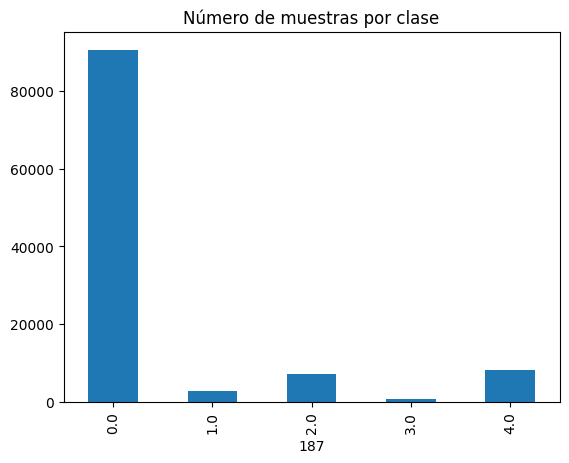

In [37]:
class_count = df.iloc[:, -1].value_counts()
print(class_count)

class_count.sort_index().plot(kind="bar", title="Número de muestras por clase")

## TODO: poner nombre de clases en la grafica

Las clases estan desbalanceadas.....

COMENTAR EN QUE NOS AFECTA Y DE QUE FORMAS SE PODRIA RESOLVER ... 

# Preprocesamiento básico

En esta sección definimos preprocesamiento básico.

Más adelante hacemos pruebas con y sin balanceo de clases para ver como afecta al resultado final.

In [46]:
# normalizar datos,  "z score" T.Normalize(mean=T_MEAN, std=T_STD),
# Ver que hacer con los NaN
# pasar a tensor X_train y_train / test 
# T.ToDtype(torch.float32, scale=True),

In [47]:
X_train = df_train.iloc[:, :-1]  # Extraemos las características
y_train = df_train.iloc[:, -1]   # Extraemos las etiquetas

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

In [48]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [ ]:
# TODO: 
class MITBIHDataSet(Dataset):
    def __init__(self, df_features, df_target, transform=None, target_transform=None):
        self.x_df = df_features.values
        self.y_df = df_target.values
        self.transform = transform
        self.target_transform = target_transform        

    def __len__(self):
        return len(self.x_df)

    def __getitem__(self, idx):
        x = torch.tensor(self.x_df[idx], dtype=torch.float32)
        y = torch.tensor(self.y_df[idx], dtype=torch.long)  # la cross-entropy loss necesita que el target sea long
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)        
        return x, y



'''
class ECGDataset(Dataset):
    """
    ECG latidos segmentados de longitud fija (187).
    Devuelve tensores para RNN con shape [T, 1].
    """
    def _init_(
        self,
        X: np.ndarray,           # shape [N, 187]
        y: np.ndarray,           # shape [N]
        transform: Optional[Callable[[np.ndarray], np.ndarray]] = None
    ):
        assert len(X) == len(y), "X e y deben tener mismo largo"
        self.X = X
        self.y = y.astype(np.int64)
        self.transform = transform

    def _len_(self) -> int:
        return len(self.X)

    def _getitem_(self, idx: int) -> Tuple[Tensor, Tensor]:
        x = self.X[idx]
        y = self.y[idx]
        if self.transform is not None:
            x = self.transform(x)
        # RNN: [T, 1]
        x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)
        y_t = torch.tensor(y, dtype=torch.long)
        return x_t, y_t

'''

# Data loaders

In [44]:
# TODO: PASAR A UTILS
# Wrapper para aplicar transformaciones
class TransformDataset(torch.Tensor):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        return self.transform(image), label

def get_dataloaders(
    X_train, y_train, train_transf=[], val_transf=[], batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
):
    """
    Función para obtener los dataloaders de entrenamiento, validación y test

    Args:
    - X_train: features del dataset
    - y_train: labels del dataset
    - train_transf: transformaciones para el dataset de entrenamiento
    - val_transf: transformaciones para el dataset de val
    - batch_size: tamaño del batch
    - num_workers: número de workers para cargar los datos
    """
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    # usando stratify para mantener distribucion de los datos
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
    )

    # aplicamos las transformaciones
    train_dataset = TransformDataset(train_dataset, train_transf)
    validation_dataset = TransformDataset(validation_dataset, test_transf)

    # creamos los dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    valid_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, valid_loader, test_loader

In [43]:
train_loader, val_loader, test_loader = get_dataloaders(
    X_train, y_train, train_transf, test_transf
)

NameError: name 'train_transf' is not defined

# Opcion sin augmentation con class weights

# Opcion con augmentation sin class weights
random oversampling / undersampling

https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/


from torch.utils.data import WeightedRandomSampler

sampler = WeightedRandomSampler(
    weights=weights_tensor,
    num_samples=len(weights_tensor),  # mismo tamaño que el dataset
    replacement=True  # importante, permite repetir ejemplos minoritarios
)


# Opcion con augmentation y con class weights

# Ver transfer learning entre nuestras pruebas

# Modelo 1: RNN basica

# Modelo 2: GRU

# Modelo 3: LSTM